# Eigen Decomposition

[Eigen decomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix), or spectral decomposition, factorizes a square symmetric matrix into its eigenvalues and eigenvectors, $X = Q \Lambda Q^T$, where the columns of $Q$ are the eigenvectors and $\Lambda$ is a diagonal matrix of corresponding eigenvalues. This tutorial looks at how to differentiate the eigenvectors $Q$ with respect to elements of the matrix $X$. We will make the technical assumption that all eigenvalues are simple otherwise well-defined derivatives do not exist.

Given a real symmetric matrix $X = X^T \in \mathbb{R}^{m \times m}$, it is well-known that a (unit) eigenvector associated with the largest eigenvalue of $X$ can be found by solving the following equality constrained optimization problem,

$$
\begin{align*}
	\begin{array}{ll}
		\text{maximize (over $u \in \mathbb{R}^{m}$)} & u^T X u \\
		\text{subject to} & u^T u = 1.
	\end{array}
\end{align*}
$$

Since the objective function $f$ is a quadratic form we could equally write it as $f(X, u) = \frac{1}{2} u^T (X + X^T) u$.

The optimality conditions for a solution $y \in \mathbb{R}^m$ to the above optimization problem are:

$$
\begin{align*}
	X y - \lambda_{\text{max}} y &= 0_{m} \\
	y^T y &= 1.
\end{align*}
$$

Indeed, any eigenvalue-eigenvector pair will also satisfy these conditions (replacing $\lambda_{\text{max}}$ with the appropriate eigenvalue). We can easily extend the above optimization problem to find all eigenvectors (and eigenvalues) of symmetric input matrix $X$ as,

$$
\begin{align*}
	\begin{array}{ll}
		\text{maximize (over $U \in \mathbb{R}^{m \times m}$)} & \textbf{tr}(U^T X U) \\
		\text{subject to} & U^T U = I_{m \times m}.
	\end{array}
\end{align*}
$$

Note also that the solution is not unique, even if all eigenvalues are simple (i.e., even if $X$ has $m$ distinct eigenvalues). Given a solution $Y$, negating and permuting columns is also a solution. We typically rely on the solver to sort eigenvectors in ascending or descending order corresponding to their eigenvalues. However, the sign ambiguity for each eigenvector is unavoidable.

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.get_device_name() if torch.cuda.is_available() else "No CUDA")

torch.manual_seed(22)

import sys
sys.path.append("../")

1.13.0
No CUDA


### Forward Pass

In the forward pass we can use PyTorch's ``torch.linalg.eigh`` function for computing all eigenvalues and eigenvectors of a symmetric matrix, which is equivalent to solving the optimisation problem above. This function can be directly back-propagated but we will develop a faster and more stable version using ideas from deep declarative networks. The following shows the forward pass code.

In [2]:
class EigenDecompositionFcn(torch.autograd.Function):
    """PyTorch autograd function for eigen decomposition of real symmetric matrices.
    The input matrix is made symmetric within the forward evaluation function."""

    eps = 1.0e-9 # tolerance to consider two eigenvalues equal

    @staticmethod
    def forward(ctx, X):
        B, M, N = X.shape
        assert N == M

        with torch.no_grad():
            lmd, Y = torch.linalg.eigh(0.5 * (X + X.transpose(1, 2)))

        ctx.save_for_backward(lmd, Y)
        return Y

### Backward Pass

Magnus (1985) gives the differentials as

$$
\begin{align*}
	\text{d} \lambda_{k} &= y_k^T (\text{d} X) y_k \\
	\text{d} y_k &= (\lambda_{k} I - X)^{\dagger} (\text{d}{X}) y_k
\end{align*}
$$

for any simple eigenvalue $\lambda_k$ and it's corresponding eigenvector $y_k$. Here $(\lambda_{k} I - X)^{\dagger}$ is the pseudo-inverse of $(\lambda_{k} I - X)$, which will be singular since we are zeroing out one of the eigenvalues. So with respect to the $(i,j)$-th component of $X$ we have

$$
\begin{align*}
	\frac{\text{d} y_k}{\text{d} X_{ij}} &= -\frac{1}{2} (X - \lambda_{k} I)^{\dagger} (E_{ij} + E_{ji}) y_k
\end{align*}
$$

where we have used the fact that $X$ is symmetrical.

To compute the gradient of the loss with respect to the $(i,j)$-th component of $X$ we need to sum over the contributions from all eigenvectors. Let $v_k^T = \frac{\text{L}}{\text{y_k}} \in \mathbb{R}^{1 \times m}$. Then,

$$
\begin{align}
	\frac{\text{d} L}{\text{d} X_{ij}} &= \sum_{k=1}^{m} v_k^T \frac{\text{d} y_k}{\text{d} X_{ij}} \\
	&= -\frac{1}{2} \sum_{k=1}^{m} v_k^T (X - \lambda_{k} I)^{\dagger} (E_{ij} + E_{ji}) y_k
\end{align}
$$

Naively implementing this expression by looping over the contribution from each eigenvector is painfully slow. We show an example of such code below.

In [3]:
class EigenDecompositionFcn_v1(torch.autograd.Function):
    """PyTorch autograd function for eigen decomposition of real symmetric matrices.
    The input matrix is made symmetric within the forward evaluation function."""

    eps = 1.0e-9 # tolerance to consider two eigenvalues equal
    
    @staticmethod
    def backward(ctx, dJdY):
        X, lmd, Y = ctx.saved_tensors
        B, M, N = dJdY.shape
        assert M == N
        
        dJdX = torch.zeros_like(X)

        # loop over eigenvalues
        for i in range(K):
            L = torch.diag_embed(lmd[:, i].repeat(M, 1).transpose(0, 1))
            w = -0.5 * torch.bmm(torch.pinverse(X - L), dJdY[:, :, i].view(B, M, 1)).view(B, M)
            dJdX += torch.einsum("bi,bj->bij", w, Y[:, :, i]) + torch.einsum("bj,bi->bij", w, Y[:, :, i])

        return dJdX, None

### Faster Backwards Pass

Recognising that $X$ can be decomposed as $Y \Lambda Y^T$ for $Y = \left[y_1 \, y_2 \, \cdots\, y_m\right] \in \mathbb{R}^{m \times m}$, which we obtain from the forward pass, we can write the gradient as

$$
\begin{align*}
	\frac{\text{d} L}{\text{d} X_{ij}} &= \sum_{k=1}^{m} v_k^T \frac{\text{d} y_k}{\text{d} X_{ij}} \\
	&= -\frac{1}{2} \sum_{k=1}^{m} v_k^T Y (\Lambda - \lambda_{k} I)^{\dagger} Y^T (E_{ij} + E_{ji}) y_k
\end{align*}
$$

and significantly speed up the various pseudo-inverse calculations in the backward pass.

In [4]:
class EigenDecompositionFcn_v2(torch.autograd.Function):
    """PyTorch autograd function for eigen decomposition of real symmetric matrices.
    The input matrix is made symmetric within the forward evaluation function."""

    eps = 1.0e-9 # tolerance to consider two eigenvalues equal

    @staticmethod
    def backward(ctx, dJdY):
        lmd, Y = ctx.saved_tensors
        B, M, N = dJdY.shape
        assert M == N

        dJdX = torch.zeros_like(Y)
        zero = torch.zeros(1, dtype=lmd.dtype, device=lmd.device)

        # loop over eigenvalues
        for i in range(K):
            L = lmd - lmd[:, i].view(B, 1)
            L = torch.where(torch.abs(L) < EigenDecompositionFcn.eps, zero, 1.0 / L)
            w = -0.5 * torch.bmm(torch.bmm(Y, L.view(B, M, 1) * Y.transpose(1, 2)), dJdY[:, :, i].view(B, M, 1)).view(B, M)
            dJdX += torch.einsum("bi,bj->bij", w, Y[:, :, i]) + torch.einsum("bj,bi->bij", w, Y[:, :, i])

        return dJdX, None

### Even Faster Backwards Pass

A even faster implementation is possible with some rearranging of terms to reuse and vectorize calculations. Considering only the term involving $E_{ij}$ and observing that $E_{ij} y_k = e_i e_j^T y_k = Y_{jk} e_i$, we have

$$
\begin{align*}
	\sum_{k=1}^{m} v_k^T Y (\Lambda - \lambda_{k} I)^{\dagger} Y^T E_{ij} y_k
	&= \sum_{k=1}^{m} Y_{jk} v_k^T Y (\Lambda - \lambda_{k} I)^{\dagger} Y^T e_i
	\\
	&= \begin{bmatrix}
		Y_{j1} & Y_{j2} & \cdots & Y_{jm}
	\end{bmatrix} \begin{bmatrix} 
		v_1^T Y (\Lambda - \lambda_{1} I)^{\dagger} \\
		v_2^T Y (\Lambda - \lambda_{2} I)^{\dagger} \\
		\vdots \\
		v_m^T Y (\Lambda - \lambda_{m} I)^{\dagger}
	\end{bmatrix} Y^T e_i
	\\
	&= e_j^T Y \begin{bmatrix} 
		v_1^T Y (\Lambda - \lambda_{1} I)^{\dagger} \\
		v_2^T Y (\Lambda - \lambda_{2} I)^{\dagger} \\
		\vdots \\
		v_m^T Y (\Lambda - \lambda_{m} I)^{\dagger}
		\end{bmatrix} Y^T e_i
	\\
	&= e_j^T Y \left( \begin{bmatrix}
		0 & \frac{1}{\lambda_2 - \lambda_1} & \cdots & \frac{1}{\lambda_m - \lambda_1} \\
		\frac{1}{\lambda_1 - \lambda_2} & 0 & \cdots & \frac{1}{\lambda_m - \lambda_2} \\
		\vdots & \vdots & \ddots & \vdots \\
		\frac{1}{\lambda_1 - \lambda_m} & \frac{1}{\lambda_2 - \lambda_m} & \ldots & 0 
	 	\end{bmatrix} \odot \begin{bmatrix} 
		v_1^T Y \\
		v_2^T Y \\
		\vdots \\
		v_m^T Y
	\end{bmatrix} \right) Y^T e_i
	\\
	&= e_j^T Y (\tilde{\Lambda} \odot V^T Y) Y^T e_i
\end{align*}
$$

where $V = \left[v_1 \, v_2 \, \cdots \, v_m \right]$ and $\tilde{\Lambda}_{ij} = \frac{1}{\lambda_i - \lambda_j}$ for $i \neq j$ and zero otherwise. The second last line is because post-multiplying a row vector by a diagonal matrix results in scaling each element of the vector by the corresponding diagonal entry. Thus we can eliminate the explicit for-loop in our backward pass code.

In [5]:
class EigenDecompositionFcn_v3(torch.autograd.Function):
    """PyTorch autograd function for eigen decomposition of real symmetric matrices.
    The input matrix is made symmetric within the forward evaluation function."""

    eps = 1.0e-9 # tolerance to consider two eigenvalues equal

    @staticmethod
    def backward(ctx, dJdY):
        lmd, Y = ctx.saved_tensors
        B, M, N = dJdY.shape
        assert M == N
        
        zero = torch.zeros(1, dtype=lmd.dtype, device=lmd.device)

        # do all eigenvalues in one go
        L = lmd.view(B, 1, M) - lmd.view(B, N, 1)
        L = torch.where(torch.abs(L) < EigenDecompositionFcn.eps, zero, 1.0 / L)
        w = torch.bmm(L * torch.bmm(dJdY.transpose(1, 2), Y), Y.transpose(1, 2))

        dJdX = torch.einsum("bik,bkj->bji", Y, w)
        dJdX = -0.5 * (dJdX + dJdX.transpose(1, 2))

        return dJdX, None

### Yet Even Faster Backward Pass

Continuing with some further algebraic manipulation we get

$$
\begin{align*}
    e_j^T Y (\tilde{\Lambda} \odot V^T Y) Y^T e_i
    &= e_i^T Y (\tilde{\Lambda}^T \odot Y^T V) Y^T e_j \\
    &= \left(Y (\tilde{\Lambda}^T \odot Y^T V) Y^T \right)_{ij} \\
    &= -\left(Y (\tilde{\Lambda} \odot Y^T V) Y^T \right)_{ij}
\end{align*}
$$

Evident from this result is that we can efficiently compute derivatives with respect to all components of $X$ using a single expression, i.e.,

$$
\begin{align*}
	\frac{\text{d} L}{\text{d} X} &= \frac{1}{2} \left(Y (\tilde{\Lambda} \odot Y^T V) Y^T \right) + \frac{1}{2} \left(Y (\tilde{\Lambda} \odot Y^T V) Y^T \right)^T
\end{align*}
$$

The following code implements the full differentiable eigen decomposition PyTorch function with hand-coded backward pass. It is also available as ``EigenDecompositionFcn`` in the ``ddn.pytorch.eigen_decomposition`` module, which also allows for computing just the top-$k$ eigenvalues and corresponding eigenvectors.

In [6]:
class EigenDecompositionFcn(torch.autograd.Function):
    """PyTorch autograd function for eigen decomposition of real symmetric matrices.
    The input matrix is made symmetric within the forward evaluation function."""

    eps = 1.0e-9 # tolerance to consider two eigenvalues equal

    @staticmethod
    def forward(ctx, X):
        B, M, N = X.shape
        assert N == M

        with torch.no_grad():
            lmd, Y = torch.linalg.eigh(0.5 * (X + X.transpose(1, 2)))

        ctx.save_for_backward(lmd, Y)
        return Y

    @staticmethod
    def backward(ctx, dJdY):
        lmd, Y = ctx.saved_tensors
        B, M, N = dJdY.shape
        assert N == M
        
        zero = torch.zeros(1, dtype=lmd.dtype, device=lmd.device)
        L = lmd.view(B, 1, N) - lmd.view(B, M, 1)
        L = torch.where(torch.abs(L) < EigenDecompositionFcn.eps, zero, 1.0 / L)
        dJdX = torch.bmm(torch.bmm(Y, L * torch.bmm(Y.transpose(1, 2), dJdY)), Y.transpose(1, 2))

        dJdX = 0.5 * (dJdX + dJdX.transpose(1, 2))

        return dJdX, None

### Profiling

We profile the running time and memory required by the various implementations. Our test is to solve the bi-level optimisation problem,

$$
\begin{align*}
	\begin{array}{ll}
		\text{minimize} & |\textbf{tr}(Y^T Y^{\text{target}})| \\
		\text{subject to} & Y = \textrm{argmax}_{U} \; \textbf{tr} (U^T X U) \\
        & \text{subject to} \; U^T U = I
	\end{array}
\end{align*}
$$

by gradient descent for a fixed number of iterations.

In [7]:
import time, os, sys
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

import torch

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.enabled = True

import torch.autograd.profiler as profiler

sys.path.append("..")
from ddn.pytorch.eigen_decomposition import EigenDecompositionFcn
sys.path.append("../tests")
from testEigenDecomposition import EigenDecompositionFcn_v1, EigenDecompositionFcn_v2, EigenDecompositionFcn_v3, speed_memory_test


def plot_profiling(device=torch.device("cpu")):
    """Speed and memory profiling."""
    data = {}
    for f in [EigenDecompositionFcn,
              EigenDecompositionFcn_v1,
              EigenDecompositionFcn_v2,
              EigenDecompositionFcn_v3]:

        torch.cuda.empty_cache()
        time_fwd, time_bck, mem = speed_memory_test(lambda X: f.apply(X, None),
            (5 if device == torch.device('cpu') else 1000, 32),
            num_iter_speed=1000, num_iter_memory=5, device=device, dtype=torch.float32)

        print(f.__name__, time_fwd, time_bck, mem)
        data[f.__name__] = {'time_fwd': time_fwd, 'time_bck': time_bck, 'total_mem': mem}

    fig, ax = plt.subplots(1, 1)
    b = plt.bar(tuple(range(5)), [data['EigenDecompositionFcn']['time_fwd'],
                                  data['EigenDecompositionFcn_v1']['time_bck'],
                                  data['EigenDecompositionFcn_v2']['time_bck'],
                                  data['EigenDecompositionFcn_v3']['time_bck'],
                                  data['EigenDecompositionFcn']['time_bck']],
                log=True, color=['r', 'b', 'b', 'b', 'b'])
    ax.set_xticks(range(5))
    ax.set_xticklabels(['fwd', 'bck (v1)', 'bck (v2)', 'bck (v3)', 'bck (final)'])
    
    # add counts above the two bar graphs
    for rect in b:
        height = rect.get_height()
        value = height / data['EigenDecompositionFcn']['time_fwd']
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{value:0.1f}x', ha='center', va='bottom')

    plt.ylabel('log time (ms)')
    plt.grid(True); plt.grid(True, which='minor', axis='y', ls='--')
    plt.tight_layout()
    plt.title("Differentiable eigen decomposition implementation comparison on {}".format(device))

EigenDecompositionFcn 0.5785785785580689 0.3613613609287951 1.9239578247070312
EigenDecompositionFcn_v1 0.8518518528083453 39.065065063737535 77.8137378692627
EigenDecompositionFcn_v2 0.8278278285754962 10.744744744217089 24.187830924987793
EigenDecompositionFcn_v3 0.6126126128102506 0.4984984986364722 2.2254724502563477


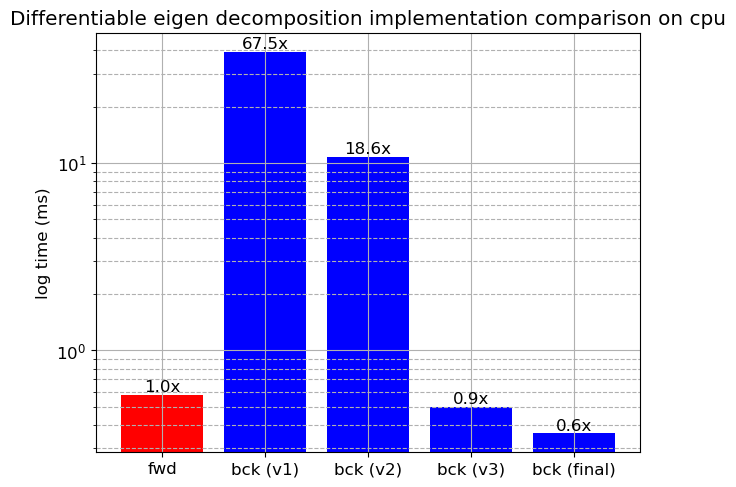

In [8]:
# profile on cpu
plot_profiling(torch.device("cpu"))
plt.show()

In [9]:
# profile on gpu
if torch.cuda.is_available():
    plot_profiling(torch.device("cuda"))
    plt.show()